<a href="https://colab.research.google.com/github/maragraziani/interpretAI_DigiPath/blob/main/concept_attribution_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Hands-on Session 1 - part 2</center>
## <center> Concept Attribution: Regression Concept Vectors (RCVs)</center>

**Presented by:**
- Mara Graziani
    - PhD student at Hes-so Valais & University of Geneva
    - mara.graziani@hevs.ch  
    
#### Content

* [Introduction & Motivation](#intro)
* [Installation & Data](#Section0)
* [RCVs for breast cancer pathology](#Section1)      
    * a. Extract diagnostic features from the images
    * b. Extract internal activations
    * c. Compute the concept vector 
    * d. Evaluate conceptual sensitivity


#### Take-away messages

* Feature attribution explains CNNs in terms of the input pixels. Its abstraction to higher level impacting factors is hard. What in the highlighted area caused the spiking activations?
*  Concept attribution explains CNNs with high-level concepts such as clinical factors. 
* *You can use it to verify if clinical expectations match the CNN decision-making*
* Nuclei pleomorphism was shown as a relevant factor in breast tumor classification.
* *You can use it to improve and refine model behavior*

<div id="Intro"></div> 

## Introduction & Motivation: Why and when should we use RCVs and concept-based attribution?

RCVs Grad-CAM is a post-hoc interpretability method that generates a localization map by visualizing the contribution of each feature map to the network prediction. The cascade of gradients is taken into account to weight the feature maps contributions.

### <center> "*We use RCVs to connect hand-crafted to deep learning feature extraction*" 

### <center> "*Use RCVs to map undertandable concepts to latent representations, of any deep model*" 


Why should we use RCVs?

- Similarly to feature attribution:
    - It is model agnostic
    - It preserves model performance
    - It is easy to apply 
- In addition:
    - It generates quantitative explanations, not only qualitative ones
    - **It explains in terms of diagnostic features: nuclei size, shape, appearance**
    - **It explains what diagnostic factors were responsible for the decision**

When should we use RCVs?

- If you already have a trained deep learning model with good performance
- For a deeper investigation about what factors are relevant in the decision-makin
- If you want to evaluate the relevance of specific features
- If you want to investigate some specific network behaviour

## RCVs for histopathology

- We start from the Nottingham Histology Grading (NHG) of Breast Cancer
- Cancerous regions show atypical nuclei organization, morphology and mitotic activity
- Deformations in the nuclei morphology consist of:
    - **enlarged** size
    - **atypical** shape
    - **vesicular** appearance, visible nucleoli, high chromatism
- We model these diagnostic criteria as numeric features

<figure class="image">
  <img src="https://raw.githubusercontent.com/maragraziani/interpretAI_DigiPath/main/hands-on-session-1/imgs/rcvs.png" width="750">
</figure>

- We learn a **direction that is representative of these criteria** in the CNN: the RCV
- We evaluate, by the RCV, the relevance of these concept to the decision as a **conceptual sensitivity** score

**References:**

1. [Graziani M., Andrearczyk V., Marchand-Maillet S., Müller H. "Concept attribution: Explaining CNN decisions to physicians" Computers in Biology and Medicine, Volume 123, 2020, 103865, ISSN 0010-4825.](https://doi.org/10.1016/j.compbiomed.2020.103865) Graziani et al., CBM, 2020.
2.  Graziani M., Andrearczyk V., Müller H. ["Regression Concept Vectors for Bidirectional Explanations in Histopathology"](https://arxiv.org/abs/1904.04520) In: Stoyanov D. et al. (eds) Understanding and Interpreting Machine Learning in Medical Image Computing Applications. MLCN 2018, DLF 2018, IMIMIC 2018. Lecture Notes in Computer Science, vol 11038. Springer, Cham. Graziani et al., iMIMIC at MICCAI, 2018.
3. [Kim, Been, Martin Wattenberg, Justin Gilmer, Carrie Cai, James Wexler, and Fernanda Viegas. "Interpretability beyond feature attribution: Quantitative Testing with Concept Activation Vectors (TCAV)." In International conference on machine learning, pp. 2668-2677. PMLR, 2018.](https://arxiv.org/pdf/1711.11279.pdf) Kim et al., ICML, 2018

<div id="Section0"></div> 

## Installation and Data 

- Install the **rcvtool** library, a python-based library to facilitate the computation of Regression Concept Vectors to deep learning models. Documentation and examples [here](https://github.com/maragraziani/ConceptAttribution)

<figure class="image">
  <img src="https://raw.githubusercontent.com/maragraziani/ConceptAttribution/master/figs/abstract.jpg" width="800">
</figure>

### Same as before: 
- Running on **Colab**: this tutorial requires a GPU. Colab allows you to use a K80 GPU for 12h. Please do the following steps:
    - Open the tab *Runtime*
    - Click on *Change Runtime Type*
    - Set the hardware to *GPU* and *Save*

- This demo uses the Camelyon dataset. To facilitate research on these challenging data, a subset of images with fixed splits called **PatchCamelyon** (PCam) was released on Kaggle for a benchmarking challenge.  You can add the full PCam dataset by selecting the option "create a shortcut to my Drive" [at this link](https://drive.google.com/drive/folders/1gHou49cA1s5vua2V5L98Lt8TiWA3FrKB?usp=sharing).

<figure class="image">
  <img src="https://raw.githubusercontent.com/basveeling/pcam/master/pcam.jpg" width="800">
</figure>
Example images from [PCam](https://github.com/basveeling/pcam).

**References:**

4. B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962
5. Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

In [ ]:
!pip install rcvtool

  Created wheel for rcvtool: filename=rcvtool-0.1.5-cp37-none-any.whl size=8716 sha256=3cf69ed0f8f5e92c76b75d5a9cac0d5429d8b68c15037809aa3b6cb469b471c2
  Stored in directory: /root/.cache/pip/wheels/df/66/2b/8091875f34198257a1317c4ee538e46d077569b8f3d8136bec
Successfully built rcvtool


# a. Extracting diagnostic features from the images

In [ ]:
import rcvtool as rcv
import sys
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import roc_curve, auc
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.disable_eager_execution()
tf.keras.backend.clear_session()

BATCH_SIZE = 32
SEED=0
NSAMPLES=30
np.random.seed(SEED)
data_folder='/content/drive/MyDrive/CNNinterpret'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Connect to data or upload data files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
y = np.load('/content/drive/MyDrive/CNNinterpret/y.npy', allow_pickle=True)
x = np.load('/content/drive/MyDrive/CNNinterpret/norm_x.npy', allow_pickle=True)
raw_x = np.load('/content/drive/MyDrive/CNNinterpret/x.npy', allow_pickle=True)
raw_x /= 255.

In [ ]:
all_cm = np.zeros(NSAMPLES)
i = 0
for img in raw_x[:NSAMPLES]:
    all_cm[i] = rcv.get_texture_measure(img, mtype='contrast')
    i += 1

# b. Extract internal activations

In [ ]:
# Loading the histopathology model finetuned from ImageNet
vgg_model = tf.keras.applications.VGG16(weights=None)
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(vgg_model.layers[-2].output)
vgg_histo_model = tf.keras.Model(vgg_model.input, predictions)
vgg_histo_model.load_weights('/content/drive/MyDrive/CNNinterpret/weights.h5')

In [ ]:
vgg_histo_model.summary()

In [ ]:
all_acts = rcv.get_batch_activations(vgg_histo_model, 'block5_conv3', x[:NSAMPLES], pooling='AVG')

# c. Compute the concept vector


In [ ]:
contrast_vector = rcv.get_rcv(all_acts,all_cm,type='global linear', evaluation=True, verbose=True)

Global linear regression under euclidean assumption
Random state:  1
R2:  1.0
TEST mse: 3814.9621543201406, r2: 0.5235697287237215


In [ ]:
contrast_vector = contrast_vector.params
contrast_vector = contrast_vector[1:]
contrast_vector /= np.linalg.norm(contrast_vector)

# d. Compute the conceptual sensitivity scores


In [ ]:
def get_directional_derivative(model, rcv_vector, reference_layer, class_id, input_image):
  """ Function to compute conceptual sensitivity scores: 
  NB. Soon it will be integrated in rcvtool. Stay tuned! """
  def gap(x):
        """Utility function to perform gap to a tensor """
        return tf.keras.backend.mean(x, axis=(1,2))
  y_c = model.output[0, class_id]
  conv_output = model.get_layer(reference_layer).output
  grads = tf.keras.backend.gradients(y_c, conv_output)[0]
  grads = gap(grads)
  directional_derivative = tf.matmul(grads, tf.expand_dims(tf.convert_to_tensor(rcv_vector, dtype=tf.float32), axis=1))
  get_derivative = tf.keras.backend.function([model.input], [directional_derivative])
  return get_derivative(input_image) [0]

In [ ]:
N_TEST_SAMPLES = 10
conceptual_sensitivities = []
for i in range(N_TEST_SAMPLES):
    conceptual_sensitivities.append(get_directional_derivative(vgg_histo_model, contrast_vector, 'block5_conv3', 0, np.expand_dims(x[i],axis=0))[0][0])

In [ ]:
conceptual_sensitivities

[0.0004343325,
 0.00021722575,
 0.00021775844,
 0.00037578426,
 0.00041768778,
 0.00042041377,
 0.00041021095,
 0.00012784227,
 0.00031585238,
 0.00026203343]

# Extending the analysis to more features

In [ ]:
def get_conceptual_sensitivities(images, preprocessing_output, model, concept_type, layer_name='block5_conv3', n_samples=N_TEST_SAMPLES):
  all_cm = np.zeros(NSAMPLES)
  i = 0
  for img in images[:NSAMPLES]:
      all_cm[i] = rcv.get_texture_measure(img, mtype=concept_type)
      i += 1
  all_acts = rcv.get_batch_activations(model, layer_name, preprocessing_output[:NSAMPLES], pooling='AVG')
  concept_vector = rcv.get_rcv(all_acts,all_cm,type='global linear', evaluation=True, verbose=True)
  concept_vector=concept_vector.params
  concept_vector=concept_vector[1:]
  concept_vector/=np.linalg.norm(concept_vector)
  conceptual_sensitivities=[]
  for i in range(n_samples):
      conceptual_sensitivities.append(get_directional_derivative(model, concept_vector, layer_name, 0, np.expand_dims(preprocessing_output[i],axis=0))[0][0])
  return conceptual_sensitivities

In [ ]:
texture_measures = ['contrast', 'correlation', 'ASM', 'homogeneity', 'dissimilarity']
sensitivity_scores = {}
for measure_type in texture_measures:
  sensitivity_scores[measure_type] = get_conceptual_sensitivities(raw_x, x, vgg_histo_model, measure_type)

Global linear regression under euclidean assumption
Random state:  1
R2:  1.0
TEST mse: 3814.9621543201406, r2: 0.5235697287237215
Global linear regression under euclidean assumption
Random state:  1
R2:  1.0
TEST mse: 0.00019320080674878337, r2: 0.4175293548131871
Global linear regression under euclidean assumption
Random state:  1
R2:  1.0
TEST mse: 0.00032345189016475136, r2: -11.688002981164377
Global linear regression under euclidean assumption
Random state:  1
R2:  1.0
TEST mse: 0.0016711785101337535, r2: 0.8226672415659737
Global linear regression under euclidean assumption
Random state:  1
R2:  1.0
TEST mse: 2.142146732876168, r2: 0.6838710021243056


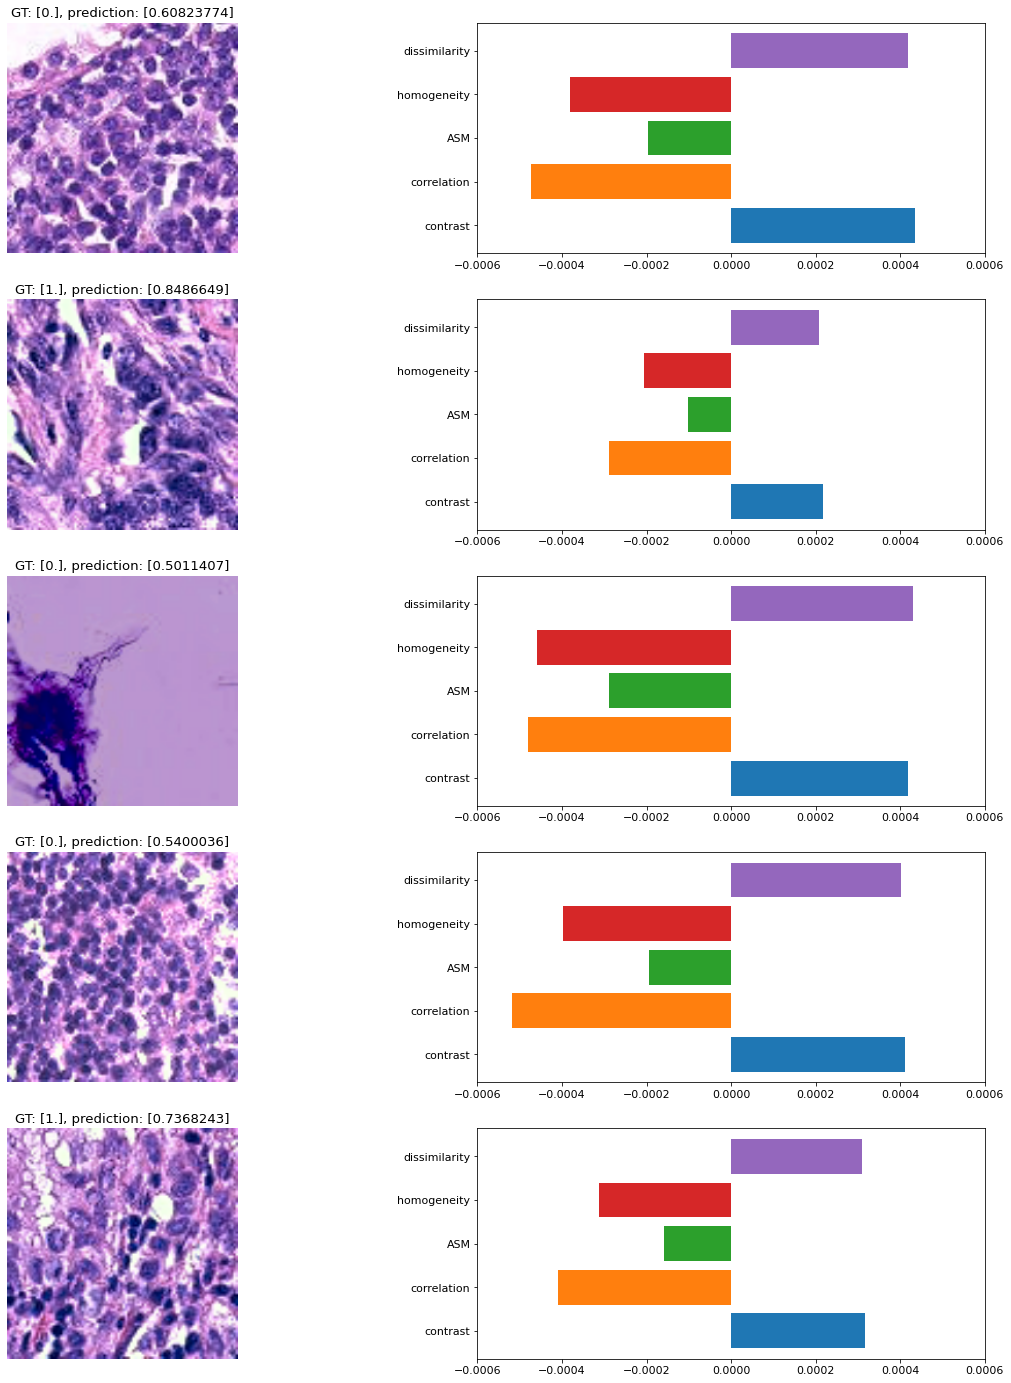

In [ ]:
plt.rcParams['figure.figsize']=(20,50)
height = N_TEST_SAMPLES
width = 2
images = raw_x*255
for idx in range(0,height,2):
  plt.rcParams['font.size']=11
  fig = plt.subplot(height, width, idx+1)
  plt.imshow(np.asarray(images[idx], dtype=np.uint8))
  plt.title('GT: {}, prediction: {}'.format(y[idx][0][0], vgg_histo_model.predict(np.expand_dims(x[idx], axis=0))[0]))
  plt.axis('off')
  fig = plt.subplot(height, width, idx+2)
  location=0
  for measure_type in texture_measures: 
      plt.barh(location, sensitivity_scores[measure_type][idx], align='center')
      location+=1
      plt.xlim(-0.0006, 0.0006)
  plt.yticks(np.arange(len(texture_measures)),texture_measures)

## How to read conceptual sensitivity scores

- A **positive** score indicates that the prediction would have increased if the concept value was higher in the image
- A **negative** score indicates that the prediction would have decreased if the concept value was higher in the image

Example: 

GT: 1, prediction: 0.7368

Positive dissimilarity and contrast show that if the texture appeared more dishomogeneous, this image would have been classified even more confidently as tumor than it is now. 
Negative homogeneity, ASM and correlation show that more homogeneous areas in the image would have decreased the prediction.


# Personalize your analysis

Multiple concepts of interest can be analyzed, depending on your investigation purposes. 

In another work, for example, we evaluated the scale covariance of the learned representations to improve the CNN performance on histopathogy tasks that depend strongly on scale: 

<figure class="image">
  <img src="https://raw.githubusercontent.com/medgift/scale_covariant_pruning/master/results/arch.png" width="800">
</figure>

If you are interested, read the paper:
-  Graziani, M.; Lompech, T.; Müller, H.; Depeursinge, A.; Andrearczyk, V. "On the Scale Invariance in State of the Art CNNs Trained on ImageNet." Mach. Learn. Knowl. Extr. 2021, 3, 374-391. [https://doi.org/10.3390/make3020019](https://www.mdpi.com/2504-4990/3/2/19)